In [2]:
!pip install wfdb

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.10/site.py", line 633, in <module>
    main()
  File "/usr/lib/python3.10/site.py", line 620, in main
    known_paths = addsitepackages(known_paths)
  File "/usr/lib/python3.10/site.py", line 403, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.10/site.py", line 232, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.10/site.py", line 192, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/importlib/util.py", line 14, in <module>
    from contextlib import contextmanager
  File "/usr/lib/python3.10/contextlib.py", line 123, in <module>
    class _GeneratorContextManager(
  File "/usr/lib/python3.10/abc.py", line 106, in __new__
    cls = super().__new__(mcls, name, bases, namespace, **kwargs)
KeyboardInterrupt


In [3]:
! pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


In [4]:
! pip install -q kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download shayanfazeli/heartbeat

 93% 92.0M/98.8M [00:00<00:00, 153MB/s]
100% 98.8M/98.8M [00:00<00:00, 147MB/s]


In [9]:
import zipfile
with zipfile.ZipFile("heartbeat.zip","r") as z:
  z.extractall(".")

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import wfdb
import tsfel
from glob import glob
import scipy.signal as sg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Using the wfdb package to download the MIT-BIH database to a local folder.
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

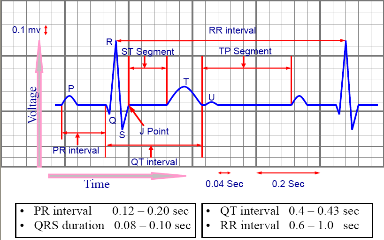

Arrhythmia Dataset

Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

This implies that for every 36 samples, 0.1 seconds have elapsed.

Maximum PR interval is 0.2 seconds, which is 36*2=72 samples from Q.
Maximum QT interval is 0.44 seconds, which is 0.44*36/0.1=158.4 samples, or 158 samples from Q.
Maximum QRS duration is 0.12 seconds, which is 43 samples.
Given x is the R's index, x - (43/2) = x-21 is the index of Q.


Most of the studies followed the Advancement of Medical Instrumentation (AAMI) recommendation, which specifies heartbeats using five labels, namely, normal or bundle branch block beat (N), supraventricular ectopic beat (S), ventricular ectopic beat (V), fusion of ventricular and normal beat (F), and heartbeats that cannot be classified (Q). This recommendation makes possible a fair comparison among various heartbeat classifiers

In [ ]:
def classify_seg(label):
  beat_type = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'f', 'Q']
  normal = ['N', 'L', 'R']
  supraventricular = ['e', 'j', 'A', 'a', 'J', 'S']
  ventricular = ['V', 'E']
  fusion = ['F']
  unclassified = ['f', 'Q']
  if not label in beat_type:
    return None
  
  if label in normal:
    return 'N'
  
  if label in supraventricular:
    return 'S'
  
  if label in ventricular:
    return 'V'

  if label in fusion:
    return 'F'
  
  if label in unclassified:
    return 'Q'

In [ ]:
# Segmentation
"""
input: record(array), annotation(object)
output: dataframe where column:time and value:amplitude of a single wave, beat label
"""
def segment(record, annotation):
  label = []
  label_loc = []
  df = pd.DataFrame(data=None, columns=range(302)) #72+158+36*2; PR_start+QT_end
  for i in range(len(annotation.symbol)): # For Lead I
    Q_index = annotation.sample[i]-21
    # segmenting from P to T with 0.1 seconds window for each side
    PR_start = Q_index-72 - 36 
    QT_end = Q_index+158 + 36
    if PR_start < 0 or QT_end > len(record): #out of boundary - edge case
      continue

    data = record[PR_start:QT_end]

    if record[annotation.sample[i]] < 0: #To prevent upside down
      data = np.negative(data)
    
    label_individual = classify_seg(annotation.symbol[i]) #Classify different labels into 5 categories
    
    if label_individual is None: # Not a beat
      continue

    label.append(label_individual)
    label_loc.append(annotation.sample[i])
    df.loc[len(df.index)] = data

  return df, label, label_loc

In [ ]:
paths = glob('mitdb/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()
print(paths)

In [ ]:
record = wfdb.rdsamp('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')

a, b = sg.butter(6, (0.01, 100), btype='bandpass', analog=True)
filtered_signal = sg.lfilter(b, a, record[0][:,0])
smoothed_signal = sg.cspline1d(filtered_signal, lamb=1000)
tb, lb, lb_C = segment(smoothed_signal, annotation)

In [ ]:
label = []
label_loc = []
df = pd.DataFrame(data=None, columns=range(226))
discarded = ['mitdb/102', 'mitdb/104', 'mitdb/107', 'mitdb/217']
for path in paths:
  if path in discarded:
    continue
  record = wfdb.rdsamp(path)
  annotation = wfdb.rdann(path, 'atr')

  #Noise Elimination
  #a, b = sg.butter(6, (0.01, 100), btype='bandpass', analog=True)
  #filtered_signal = sg.lfilter(b, a, record[0][:,0])
  #smoothed_signal = sg.cspline1d(filtered_signal, lamb=1000)

  #table_ind, label_ind, label_loc_ind = segment(smoothed_signal, annotation)

  table_ind, label_ind, label_loc_ind = segment(record[0][:,0], annotation)
  label = np.concatenate((label, label_ind), axis=None)
  label_loc = np.concatenate((label_loc, label_loc_ind), axis=None)
  df = pd.concat([df, table_ind], ignore_index=True, sort=False)

In [ ]:
# There are 82992 waves that are classified in either ['N', 'S', 'V', 'F', 'Q'], where each wave is constitued of 226 samples.
df

In [ ]:
print(label)
print(label.shape)

In [ ]:
normal = df[label == 'N']
supra = df[label == 'S']
ventricular = df[label == 'V']
fusion = df[label == 'F']
question = df[label == 'Q']

print(normal.shape, supra.shape, ventricular.shape, fusion.shape, question.shape)

In [ ]:
fig, axes = plt.subplots(5,5,figsize=(15,10))
lst = [normal, supra, ventricular, fusion, question]
for i in range(5):
  for j in range(5):
    axes[i][j].plot(range(302), lst[j].iloc[i+10])

axes[0][0].set_title("Normal (N)")
axes[0][1].set_title("Supraventricular Ectopic Beat (S)")
axes[0][2].set_title("ventricular ectopic beat (V)")
axes[0][3].set_title("Fusion of ventricular and normal beat (F)")
axes[0][4].set_title("Cannot classify (Q)")

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(5,5,figsize=(15,10))
lst = [normal, supra, ventricular, fusion, question]
for i in range(5):
  for j in range(5):
    axes[i][j].plot(range(302), lst[j].iloc[i])

axes[0][0].set_title("Normal (N)")
axes[0][1].set_title("Supraventricular Ectopic Beat (S)")
axes[0][2].set_title("ventricular ectopic beat (V)")
axes[0][3].set_title("Fusion of ventricular and normal beat (F)")
axes[0][4].set_title("Cannot classify (Q)")

fig.tight_layout()

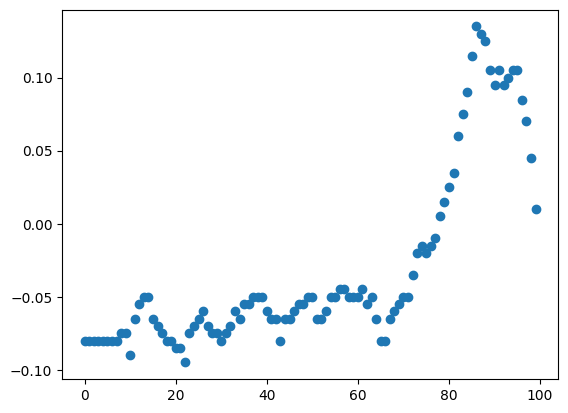

In [ ]:
plt.scatter(x=range(100), y=record[0][:100,0])

In [13]:
# Preprocessed dataset (!!!)
# Data link: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
# Preprocessing methoddescribed in III of https://arxiv.org/pdf/1805.00794.pdf
# Already comes with 0.2 train test split
# Columns 1-187 are data, column 188 is class labels


dftrain = pd.read_csv("mitbih_train.csv", header=None)#, error_bad_lines=False)
dftest = pd.read_csv("mitbih_test.csv", header=None)

dftrain.tail()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87553,0.901506,0.845886,0.800695,0.748552,0.687138,0.599073,0.512167,0.427578,0.395133,0.402086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [14]:
Xtrain = np.array(dftrain.loc[:, dftrain.columns != 187])
ytrain = np.array(dftrain[187])
Xtest = np.array(dftest.loc[:, dftest.columns != 187])
ytest = np.array(dftest[187])

print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

# note to self: might need to reshape

(87554, 187)
(87554,)
(21892, 187)
(21892,)


In [15]:
# added code for an svm, probably would also work better if we redid the data to have the same number of samples per category
# https://www.kaggle.com/code/samaherajili/svm-train-test

from sklearn.svm import SVC
import seaborn as sns
from sklearn import metrics
#Create a svm Classifier
#classifier = SVC(kernel='linear', decision_function_shape='ovo') # Linear Kernel
classifier = SVC(kernel='rbf')
#poly and rbf kernels work better than linear and sigmoid

#Train the model using the training sets
classifier.fit(Xtrain, ytrain)

#Predict the response for test dataset
ypred = classifier.predict(Xtest)


In [ ]:

print("Accuracy:",metrics.accuracy_score(ytest, ypred))

print("Training score", classifier.score(Xtrain,ytrain))
print("Testing score", classifier.score(Xtest,ytest))

Accuracy: 0.9680248492600037


<Axes: >

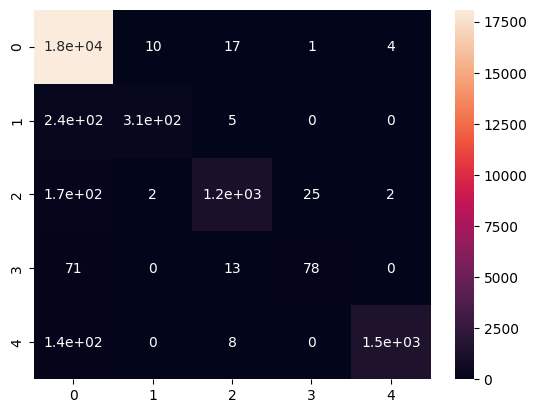

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
#sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
sns.heatmap(cm, annot=True)

In [ ]:
# CNN 

input_shape = (187, 1)

# Reshape here
Xtrain = Xtrain.reshape(Xtrain.shape[0], input_shape[0], 1)
Xtest = Xtest.reshape(Xtest.shape[0], input_shape[0], 1)

#Converted the labels
num_classes = len(np.unique(ytrain))
ytrain = keras.utils.to_categorical(ytrain, num_classes)
ytest = keras.utils.to_categorical(ytest, num_classes)

# model
model = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, ytrain, validation_split=0.2, epochs=10, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(Xtest, ytest)

Epoch 1/10
1095/1095 [==============================] - 41s 35ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 73.3463 - val_accuracy: 0.1387
Epoch 2/10
1095/1095 [==============================] - 38s 35ms/step - loss: 1.2367e-05 - accuracy: 1.0000 - val_loss: 90.0276 - val_accuracy: 0.1387
Epoch 3/10
1095/1095 [==============================] - 39s 36ms/step - loss: 1.2902e-04 - accuracy: 1.0000 - val_loss: 89.5419 - val_accuracy: 0.1387
Epoch 4/10
1095/1095 [==============================] - 41s 37ms/step - loss: 1.8348e-05 - accuracy: 1.0000 - val_loss: 75.1054 - val_accuracy: 0.1387
Epoch 5/10
1095/1095 [==============================] - 39s 36ms/step - loss: 1.5830e-04 - accuracy: 1.0000 - val_loss: 130.1016 - val_accuracy: 0.1387
Epoch 6/10
1095/1095 [==============================] - 39s 35ms/step - loss: 1.7513e-05 - accuracy: 1.0000 - val_loss: 101.2592 - val_accuracy: 0.1387
Epoch 7/10
1095/1095 [==============================] - 38s 35ms/step - loss: 8.0585e-06 - accur

In [ ]:
# another compilation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# model
model = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=num_classes, activation='softmax')
])

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min')

# Train the model
history = model.fit(
    Xtrain, ytrain,
    batch_size=128,
    epochs=50,
    validation_data=(Xtest, ytest),
    callbacks=[early_stopping, lr_schedule]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test accuracy:', test_acc)

Epoch 1/50
685/685 [==============================] - 180s 256ms/step - loss: 0.3644 - accuracy: 0.9016 - val_loss: 0.1725 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 2/50
685/685 [==============================] - 172s 250ms/step - loss: 0.1811 - accuracy: 0.9493 - val_loss: 0.1250 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 3/50
685/685 [==============================] - 170s 249ms/step - loss: 0.1510 - accuracy: 0.9582 - val_loss: 0.1144 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 4/50
685/685 [==============================] - 169s 247ms/step - loss: 0.1624 - accuracy: 0.9537 - val_loss: 0.0990 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 5/50
685/685 [==============================] - 172s 251ms/step - loss: 0.1153 - accuracy: 0.9673 - val_loss: 0.0897 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/50
685/685 [==============================] - 174s 254ms/step - loss: 0.0999 - accuracy: 0.9719 - val_loss: 0.0845 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 7/50
685/685 [==========================